In [1]:
!pip freeze > requirements_analysis.txt

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


### Init libraries and load data

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import time
import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, UnitNormalization, RandomFlip, RandomRotation, RandomBrightness, RandomContrast
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, VGG19, MobileNetV2, ResNet152V2, ResNet50
from skimage.transform import resize
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


from google.colab import drive
drive.mount("/content/gdrive")

################ CHANGE THIS TO YOUR OWN DIRECTORY ########################
path = '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition'

############################################################################



final_pass_dir = path+'/FINAL PASSES'
augmented_dir = path+'/FINAL PASSES'
results_dir =  path+'/DATA_ANALYSIS_FINALS/Results'
npy_file=path + '/DATA_HUMBOLDT_FINAL/Humboldt_crop_200_300_color_FINAL.npy'

data=np.load(npy_file, allow_pickle=True)
images=data['np_images']
if np.max(images) > 1: images = images/255.0

df = data['info_images']





Mounted at /content/gdrive


The following function must be used if you are using Keras 3, but loading models saved in Keras 2.15



In [ ]:
def my_load_model(path, compile=None):
    """Loads a TensorFlow SavedModel and wraps it in a Keras Model for inference.

    Args:
      path: The path to the TensorFlow SavedModel directory.

    Returns:
      A Keras Model that can be used for inference with predict_proba.
    """


    # Load the SavedModel as a TFSMLayer
    tfsm_layer = tf.keras.layers.TFSMLayer(
        path, call_endpoint='serving_default'  # Adjust call_endpoint if necessary
    )

    # extract the input shape
    loaded_model = tf.saved_model.load(path)

    # Access the specific endpoint (e.g., 'serving_default')
    concrete_func = loaded_model.signatures['serving_default']

    # Get the input shapes from the concrete function
    for input_name, tensor_spec in concrete_func.structured_input_signature[1].items():
        input_shape = tensor_spec.shape[1:]

    # Create a Keras Input layer with the required shape
    input_layer = tf.keras.Input(shape=input_shape)

    # Pass the input layer to the TFSMLayer
    output_tensor = tfsm_layer(input_layer)

    # Create a Keras Model
    model = tf.keras.Model(inputs=input_layer, outputs=output_tensor)


    model.model_path = path

    return model


def get_input_shape(model):

    model_path = model.model_path
    ## we add the input shape to the model
    loaded_model = tf.saved_model.load(model_path)

    # Access the specific endpoint (e.g., 'serving_default')
    concrete_func = loaded_model.signatures['serving_default']

    # Get the input shapes from the concrete function
    for input_name, tensor_spec in concrete_func.structured_input_signature[1].items():
        input_shape = tensor_spec.shape


    return input_shape


if tf.keras.__version__[0]=='3':
  print('Substituing keras load_model by custom version')
  load_model = my_load_model

Substituing keras load_model by custom version


### Define Functions

In [ ]:
def create_translation_dict(string_list):
    unique_strings = sorted(set(string_list))
    translation_dict = {string: i for i, string in enumerate(unique_strings)}
    return translation_dict

def translate_to_integers(string_list, translation_dict):
    return [translation_dict[string] for string in string_list]

def entropy(p, normalize=True ):
    # entropy of single vector
    p_n=p/np.sum(p) #normalize just in case
    logs = np.array([0 if x==0 else np.log(x) for x in p_n])
    S = - np.sum(p_n*logs)
    if normalize:
        S=S/np.log(len(p))
    return S

def proba2Entropy(y_proba):
    #entropy of dataset of vectors
    L = len(y_proba)
    S = np.zeros(L)
    for i in range(L):
      S[i] = entropy(y_proba[i])
    return S

def predict_proba(X_data, model):
    try:
      n_channels = model.layers[0].input_shape[0][-1]
    except:
      n_channels = get_input_shape(model)[-1]
    if n_channels ==1:
        X_t = np.squeeze(tf.image.rgb_to_grayscale(X_data).numpy())
    else:
        X_t = X_data
    y_proba_pred = model.predict(X_t)['classification_layer']
    return y_proba_pred

def predict(X_data, model):
    y_proba_pred = predict_proba(X_data, model)
    class_pred = y_proba_pred.argmax(axis=1)
    return class_pred


def  predict_proba_ensemble(X_data, ensemble, detail_prediction = False):
    predictions_list = []
    for model in ensemble:
        #print(model)
        y_proba_pred = predict_proba(X_data, model)
        predictions_list.append(y_proba_pred)

    all_preds = np.stack(predictions_list, axis=-1)
    av_pred = np.mean(all_preds, axis=-1)
    av_pred = av_pred[:, :, np.newaxis]
    if detail_prediction:
      out = np.concatenate((av_pred, all_preds), axis=-1)
    else: out = av_pred

    return out

def  predict_ensemble(X_data, ensemble, detail_prediction = False):
    full_prediction_proba = predict_proba_ensemble(X_data, ensemble, detail_prediction = detail_prediction)
    class_pred = full_prediction_proba.argmax(axis=1)

    return class_pred


def evaluate_metrics(test_pred, y_test):
    true_labels = y_test
    N_models = test_pred.shape[-1]

    model_metrics = {}

    for i in range(N_models):
        predictions = test_pred[:,i]
        accuracy = accuracy_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions, average='macro')
        precision = precision_score(true_labels, predictions, average='macro')
        f1 = f1_score(true_labels, predictions, average='macro')

        namemodel = f'model{i}' if i>0 else 'ensemble'

        model_metrics[namemodel] = {
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
            'f1': f1
        }

    metrics_df = pd.DataFrame(model_metrics)
    return metrics_df

#### DATA GENERATIONS ###

def get_data_A():

  A_test_select = df['P']==100
  A_test = images[A_test_select]
  A_test_classes = df[df['P']==100]['ind_name'].values

  class_dict_test = create_translation_dict(A_test_classes)
  A_y_test = translate_to_integers(A_test_classes, class_dict_test)

  # Generic names for all exps.
  X_test = A_test.copy()
  y_test = A_y_test.copy()

  return X_test, y_test

def get_data_Unknowns():

  B_adults_test_select = df['B_adult_test_val']==1
  B_adults_test = images[B_adults_test_select]
  B_y_test = [-1]*len(B_adults_test)

  # Generic names for all exps.
  X_test = B_adults_test
  y_test = B_y_test

  return X_test, y_test


def create_ensemble_from_list(model_paths, verbatim = True, fullpath=False):
    N_models = len(model_paths)
    ensemble = []
    print('Loading models...')
    for i,model_name in enumerate(model_paths):
      if not fullpath:
        full_model_name = final_pass_dir+'/'+model_name+'/model'
      else:
        full_model_name = model_name+'/model'


        NN = my_load_model(full_model_name, compile = False)
        ensemble.append(NN)
        if verbatim:
          print(f'model {i+1} of {N_models} added: {model_name}')
    return ensemble


def create_ensemble(MODEL_TO_USE = 'H_A_09', verbatim = True):
    model_paths = [mp for mp in os.listdir(final_pass_dir) if MODEL_TO_USE in mp]
    N_models = len(model_paths)
    print(model_paths)
    if N_models==0:
        print(f'== NO MODELS WITH THAT CODE ==')
    else:
        CL = ('CL' in model_paths[0])
        print(f'There are {N_models} models, and CL mode is {CL}')


    #if not CL: X_test = np.squeeze(tf.image.rgb_to_grayscale(X_test).numpy())

    ensemble = []
    print('Loading models...')
    for i,model_name in enumerate(model_paths):
        full_model_name = final_pass_dir+'/'+model_name+'/model'

        NN = load_model(full_model_name, compile = False)
        #print(f'model {i+1} of {N_models} adding: {model_name}')
        ensemble.append(NN)
        if verbatim:
          print(f'model {i+1} of {N_models} added: {model_name}')
    return ensemble





## Select EXP and test sets

In [ ]:
X_test_A, y_test_A  = get_data_A()
X_test_UNK, y_test_UNK  = get_data_Unknowns()


## Experiment A.

**Exploration of models with P=60  + final pass**

Here, we have the final network with some modifications (batch_size in [2,4,8], and gray in [False, True]

For each of the **versions**,  we have computed 5 instances, and we report different performance metrics (accuracy, recall, precission, F1-score) for each each instance. we also report the average of the instance metrics, and the metrics for the ensemble model.

The 60+ models availables are the following
- H_A_09  (batch = 4, gray = False)
- H_A_10  (batch = 4, gray = True)
- H_A_11  (batch = 2, gray = False)
- H_A_12  (batch = 2, gray = True)
- H_A_13  (batch = 8, gray = False)
- H_A_14  (batch = 8, gray = True)

All this models are in the Final Passes directory, and have at least 5 instances.




## Create and Evaluate Ensemble for KNOWNS.

These models are all p=60, and a final pass with the validation test included (val =20%, so it is a p=80% effective model) and for each model we have ensemble of 5.
Final accuracy of the ensemble models are saved in csv files.

Change `recalculate =True` if you want to redo all the ensemble, recompute the performance and rewrite the file *ensemble_A_Final_Passes.csv*.  As os 2024 in Google Colab, with a T4 GPU, it takes a while...



In [ ]:
recalculate = False
models_A = ['H_A_09', 'H_A_10', 'H_A_10', 'H_A_11', 'H_A_12', 'H_A_13', 'H_A_14']


all_models_A = [final_pass_dir+'/'+m for m in os.listdir(final_pass_dir) if m[0:3]=='H_A']

name_out = 'ensemble_A_Final_Passes'
metrics_A = []

if recalculate:
  for this_model in models_A:
    print(this_model)
    #this_model = 'H_A_09'
    p=60
    models_to_aggregate = [m for m in all_models_A if this_model in m][0:5]
    print(models_to_aggregate)
    ensemble = create_ensemble_from_list(model_paths = models_to_aggregate, verbatim = True, fullpath=True)

    A_test_pred_proba = predict_proba_ensemble(X_test_A, ensemble, detail_prediction = True)
    A_test_pred = predict_ensemble(X_test_A, ensemble, detail_prediction = True)
    df_metric = evaluate_metrics(A_test_pred, y_test_A)
    print(f'saving model {this_model}')
    df_metric['model'] = this_model
    df_metric['average'] =  df_metric[['model1', 'model2', 'model3', 'model4', 'model5']].mean(axis=1)
    df_metric['std'] =  df_metric[['model1', 'model2', 'model3', 'model4', 'model5']].std(axis=1)
    df_metric['P'] = p

    # Retain only 5 models
    df_metric= df_metric[['model','P', 'ensemble',	'average', 'std', 'model1',	'model2',	'model3',	'model4',	'model5']]
    name_to_save = results_dir+'/'+name_out+'_'+this_model+'.csv'
    #df_metric.to_csv(results_dir+'/'+name_out+'_'+this_model+'.csv', sep=',', index=True)
    metrics_A.append(df_metric)


  metric_df_A = pd.concat(metrics_A)
  metric_df_A.reset_index(inplace=True, drop=False)
  metric_df_A.rename(columns = {'index':'metric'}, inplace=True)
  metric_df_A.to_csv(results_dir+'/'+name_out+'.csv', sep=',', index=False)

  metric_df_A


We read the results, specially the **accuracy per model**




In [ ]:
name_out = 'ensemble_A_Final_Passes'
metric_df_A = pd.read_csv(results_dir+'/'+name_out+'.csv', sep=',')
accuracy_A = metric_df_A[metric_df_A['metric']=='accuracy']
accuracy_A

metric   model   P  ensemble   average       std    model1    model2  \
0   accuracy  H_A_09  60  0.983240  0.964246  0.023236  0.955307  0.977654   
4   accuracy  H_A_10  60  0.983240  0.981006  0.009348  0.977654  0.988827   
8   accuracy  H_A_10  60  0.983240  0.981006  0.009348  0.977654  0.988827   
12  accuracy  H_A_11  60  0.983240  0.960894  0.014781  0.955307  0.966480   
16  accuracy  H_A_12  60  0.994413  0.974302  0.017929  0.983240  0.944134   
20  accuracy  H_A_13  60  0.983240  0.983240  0.003950  0.983240  0.983240   
24  accuracy  H_A_14  60  0.983240  0.981006  0.003060  0.983240  0.983240   

      model3    model4    model5  
0   0.977654  0.983240  0.927374  
4   0.966480  0.983240  0.988827  
8   0.966480  0.983240  0.988827  
12  0.983240  0.955307  0.944134  
16  0.983240  0.972067  0.988827  
20  0.977654  0.983240  0.988827  
24  0.977654  0.983240  0.977654

## DECREASING TRAINING SIZE

Now that we have set the benchmark model fro P=60+20, we evaluate the model for other values of p. In this case, we use the validation set only as an indicator, but we do not do the final pass.

For each value of P (2,5,10,20,3,40,50) we have
- 5 models *without* augmentation **B_pp_F_xx** (where PP is the P value, and xx the number of instance)
- 5 models *with* augmentation **B_pp_F_aug_xx** (where PP is the P value, and xx the number of instance)

The average and the ensemble will also be computed for models with ahd without augmentation separately.



**Augmentation factors:**

- rotation_factor = 0.1
- brightness_factor = 0.001
- contrast_range = 0.4
- h_factor = 0.3
- w_factor = 0.3

#########


## 1 EXPERIMENT B_a: Decreasing P without augmentation

Compare the inference performance of ensemlble lodels trained with different train sized. The NN models do not use augmentation, and therefore, they a a bit faster to train.

Names explained:

- **H_B10** = ensemble trained on **H**umboldt data using **10%** of the dataset.

- **H_B05_02** = ensemble trained on **H**umboldt data using **5%** of the dataset. We had some technical issue when creating the first ensemble (probably code bug) and after review, we created a **02** ensemble. We kept the label to report this.



the results will be saved as `ensemble_B_NO_Aug.csv`



Change `recalculate =True` if you want to redo all the ensemble, recompute the performance and rewrite the file *ensemble_B_NO_Aug.csv*.  As os 2024 in Google Colab, with a T4 GPU, it takes a while...


In [ ]:
recalculate = False

models_B = ['H_B02_03', 'H_B05_02',  'H_B10', 'H_B20','H_B30','H_B40', 'H_B50', 'H_B60']


all_models_B = [final_pass_dir+'/'+m for m in os.listdir(final_pass_dir) if m[0:3]=='H_B']
print(all_models_B)
name_out = 'ensemble_B_No_Aug'
metrics_B_NoAug = []

if recalculate:
  for this_model in models_B:
    print(this_model)
    P=int(this_model.split('_')[1][1:])

    models_to_aggregate = [m for m in all_models_B if this_model in m][0:5]
    print(models_to_aggregate)
    ensemble = create_ensemble_from_list(model_paths = models_to_aggregate, verbatim = True, fullpath=True)
    A_test_pred_proba = predict_proba_ensemble(X_test_A, ensemble, detail_prediction = True)
    A_test_pred = predict_ensemble(X_test_A, ensemble, detail_prediction = True)
    df_metric_B = evaluate_metrics(A_test_pred, y_test_A)
    df_metric_B['model'] = this_model
    df_metric_B['average'] =  df_metric_B[['model1', 'model2', 'model3', 'model4', 'model5']].mean(axis=1)
    df_metric_B['std'] =  df_metric_B[['model1', 'model2', 'model3', 'model4', 'model5']].std(axis=1)
    df_metric_B['P']=P
    df_metric_B= df_metric_B[['model','P', 'ensemble',	'average','std', 'model1',	'model2',	'model3',	'model4',	'model5']]
    metrics_B_NoAug.append(df_metric_B)


  metric_df_B = pd.concat(metrics_B_NoAug)
  metric_df_B.reset_index(inplace=True, drop=False)
  metric_df_B.rename(columns = {'index':'metric'}, inplace=True)
  metric_df_B.to_csv(results_dir+'/'+name_out+'.csv', sep=',', index=False)

name_out = 'ensemble_B_No_Aug'
metric_df_B_noAug = pd.read_csv(results_dir+'/'+name_out+'.csv', sep=',')
accuracy_B_noAug = metric_df_B_noAug[metric_df_B_noAug['metric']=='accuracy']
accuracy_B_noAug


['/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B30_01_FINAL-FINAL_PASS_01', '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B30_01_FINAL-FINAL_PASS_02', '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B30_01_FINAL-FINAL_PASS_03', '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B30_01_FINAL-FINAL_PASS_04', '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B30_01_FINAL-FINAL_PASS_05', '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B40_01_FINAL-FINAL_PASS_01', '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B40_01_FINAL-FINAL_PASS_02', '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B40_01_FINAL-FINAL_PASS_03', '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_B40_01_FINAL-FINAL_PASS_04', '/content

metric     model   P  ensemble   average       std    model1    model2  \
0   accuracy  H_B02_03   2  0.631285  0.531844  0.036291  0.497207  0.491620   
4   accuracy  H_B05_02   5  0.793296  0.739665  0.037601  0.782123  0.715084   
8   accuracy     H_B10  10  0.905028  0.860335  0.027369  0.882682  0.860335   
12  accuracy     H_B20  20  0.972067  0.930726  0.017037  0.927374  0.938547   
16  accuracy     H_B30  30  0.966480  0.947486  0.009348  0.944134  0.955307   
20  accuracy     H_B40  40  0.966480  0.929609  0.025171  0.921788  0.960894   
24  accuracy     H_B50  50  0.983240  0.975419  0.006370  0.966480  0.977654   
28  accuracy     H_B60  60  0.983240  0.955307  0.029296  0.955307  0.966480   

      model3    model4    model5  
0   0.553073  0.541899  0.575419  
4   0.776536  0.698324  0.726257  
8   0.882682  0.860335  0.815642  
12  0.955307  0.921788  0.910615  
16  0.955307  0.949721  0.932961  
20  0.893855  0.944134  0.927374  
24  0.972067  0.983240  0.977654  
28  0.972067  0.905028  0.977654

## 1 EXPERIMENT B_b: Decreasing P **with** augmentation

Compare the inference performance of ensemlble lodels trained with different train sized. The NN models use augmentation, and therefore, they a a bit slower to train, but acccuracy increase, specially for those models trained wit small datasets.

the results will be saved as `ensemble_B_Aug.csv`

Change `recalculate =True` if you want to redo all the ensemble, recompute the performance and rewrite the file *ensemble_B_NO_Aug.csv*.  As os 2024 in Google Colab, with a T4 GPU, it takes a while...

In [ ]:
recalculate = False

models_B_Aug = ['H_B02_AUG_04', 'H_B05_AUG_03', 'H_B10_AUG_01', 'H_B20_AUG_01',  'H_B30_AUG_01',  'H_B40_AUG_01', 'H_B50_AUG_01', 'H_B60_AUG_01']
all_models_B_Aug = [augmented_dir+'/'+m for m in os.listdir(augmented_dir) if m[0:3]=='H_B']
name_out_Aug = 'ensemble_B_Aug'
metrics_B_Aug = []

if recalculate:
  for this_model in models_B_Aug:
    p = int(this_model.split('_')[1][1:])
    models_to_aggregate = [m for m in all_models_B_Aug if this_model in m][0:5]


    ensemble = create_ensemble_from_list(model_paths = models_to_aggregate, verbatim = True, fullpath=True)
    A_test_pred_proba = predict_proba_ensemble(X_test_A, ensemble, detail_prediction = True)
    A_test_pred = predict_ensemble(X_test_A, ensemble, detail_prediction = True)
    df_metric_B_Aug = evaluate_metrics(A_test_pred, y_test_A)
    df_metric_B_Aug['model'] = this_model
    df_metric_B_Aug['average'] =  df_metric_B_Aug[['model1', 'model2', 'model3', 'model4', 'model5']].mean(axis=1)
    df_metric_B_Aug['std'] =  df_metric_B_Aug[['model1', 'model2', 'model3', 'model4', 'model5']].std(axis=1)
    df_metric_B_Aug['P']=p
    df_metric_B_Aug= df_metric_B_Aug[['model','P', 'ensemble',	'average','std', 'model1',	'model2',	'model3',	'model4',	'model5']]
    metrics_B_Aug.append(df_metric_B_Aug)


  metric_df_B_Aug = pd.concat(metrics_B_Aug)
  metric_df_B_Aug.reset_index(inplace=True, drop=False)
  metric_df_B_Aug.rename(columns = {'index':'metric'}, inplace=True)
  metric_df_B_Aug.to_csv(results_dir+'/'+name_out_Aug+'.csv', sep=',', index=False)

name_out = 'ensemble_B_Aug'
metric_df_B_Aug = pd.read_csv(results_dir+'/'+name_out+'.csv', sep=',')
accuracy_B_Aug = metric_df_B_Aug[metric_df_B_Aug['metric']=='accuracy']
accuracy_B_Aug

metric         model   P  ensemble   average       std    model1  \
0   accuracy  H_B02_AUG_04   2  0.620112  0.535196  0.072669  0.631285   
4   accuracy  H_B05_AUG_03   5  0.865922  0.831285  0.028595  0.843575   
8   accuracy  H_B10_AUG_01  10  0.927374  0.882682  0.041053  0.899441   
12  accuracy  H_B20_AUG_01  20  0.977654  0.943017  0.031701  0.916201   
16  accuracy  H_B30_AUG_01  30  0.988827  0.969832  0.014022  0.955307   
20  accuracy  H_B40_AUG_01  40  0.983240  0.972067  0.006842  0.972067   
24  accuracy  H_B50_AUG_01  50  0.988827  0.954190  0.049560  0.977654   
28  accuracy  H_B60_AUG_01  60  0.988827  0.976536  0.004674  0.972067   

      model2    model3    model4    model5  
0   0.446927  0.491620  0.581006  0.525140  
4   0.843575  0.798883  0.804469  0.865922  
8   0.910615  0.810056  0.899441  0.893855  
12  0.921788  0.921788  0.977654  0.977654  
16  0.983240  0.972067  0.983240  0.955307  
20  0.977654  0.972067  0.977654  0.960894  
24  0.972067  0.983240  0.972067  0.865922  
28  0.977654  0.983240  0.977654  0.972067

## 1 EXPERIMENT B_c: Decreasing P for **previous models**

Previous models are
- **I3S** which refers to a model with reference points (optimal) and 18 extracted points,
- **Wild ID**

For those, we have all the P values, but for the moment we onmy show up to 20 to be in line with out method.

The data for previous method are frpm 0 to 100, so we rescale dividing by 100 to have the same units in al experiments.

We can also add here the resuls for I3S, we create a version up to 20 to compare with our models. We need to divide by 100 to hace same scale

In [ ]:
name_previous = 'I3S_WildID_Test_Accuracy_Results'
metric_df_previous = pd.read_csv(results_dir+'/'+name_previous+'.csv', sep=',')
metric_df_previous['Wild_ID']=metric_df_previous['acc_test_Wild_ID']/100
metric_df_previous['I3S_optimal'] = metric_df_previous['acc_test_I3S_optimal']/100
metric_df_previous['P'] =  metric_df_previous['Exp_name'].astype(int)
acccuracy_previous =metric_df_previous[['P',	'min_n_pic',	'max_n_pic',		'I3S_optimal',	'Wild_ID']]

acccuracy_previous = acccuracy_previous[acccuracy_previous.P<80]
acccuracy_previous


P  min_n_pic  max_n_pic  I3S_optimal  Wild_ID
0   2          2          2      0.39664  0.35754
1   5          3          4      0.79329  0.39664
2  10          5          6      0.86034  0.40782
3  20          9         12      0.87709  0.45251
4  30         13         18      0.89385  0.52514
5  40         17         24      0.89944  0.56424
6  50         21         29      0.93296  0.55866
7  60         26         35      0.93296  0.58101

==============================

# Plot accuracy
Next we show the accuracies for the average and the ensemble using the dataframes:

- accuracy_B_noAug
- accuracy_B_Aug
- acccuracy_previous


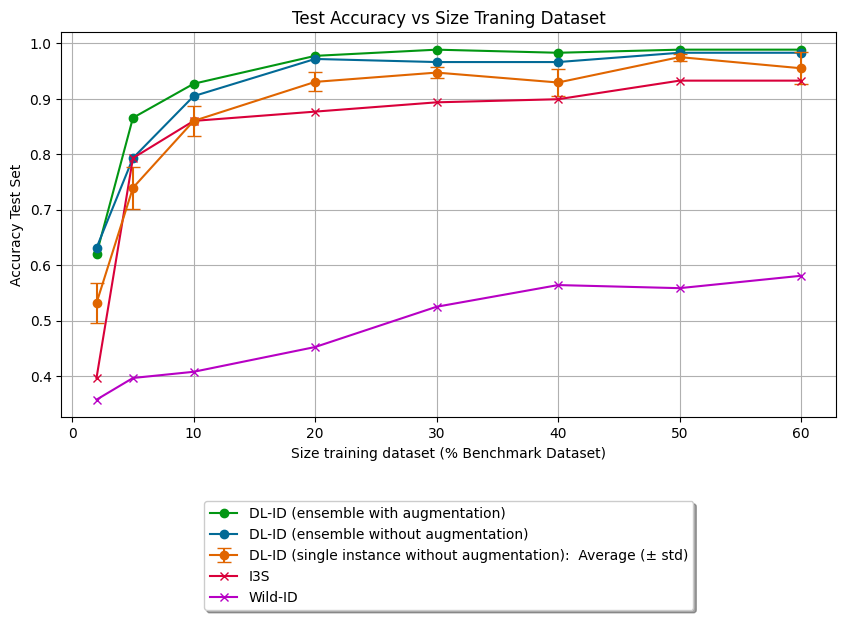

In [ ]:


c_deepId_ens_Aug = '#029613'
c_deepId_ens_NoAug = '#026a96'
c_deepId_single = '#e06500'
c_i3S = '#d9003a'
c_wild_id = '#b700c4'

plt.figure(figsize=(10, 5))

# Plot for 'Deep_ID' values
plt.plot(accuracy_B_Aug['P'], accuracy_B_Aug['ensemble'], label='DL-ID (ensemble with augmentation)',
         color = c_deepId_ens_Aug, marker='o')

plt.plot(accuracy_B_noAug['P'], accuracy_B_noAug['ensemble'], label='DL-ID (ensemble without augmentation)',
         color = c_deepId_ens_NoAug, marker='o')

plt.errorbar(accuracy_B_noAug['P'], accuracy_B_noAug['average'], yerr=accuracy_B_noAug['std'],
             label='DL-ID (single instance without augmentation):  Average (\u00B1 std)',
             color = c_deepId_single , fmt='o-', capsize=5)


# adding values for previous methods

plt.plot(acccuracy_previous['P'],acccuracy_previous['I3S_optimal'], label='I3S', color =c_i3S ,  marker='x')
plt.plot(acccuracy_previous['P'], acccuracy_previous['Wild_ID'], label='Wild-ID', color = c_wild_id, marker='x')



# Adding labels and legend
plt.xlabel('Size training dataset (% Benchmark Dataset)')
plt.ylabel('Accuracy Test Set')
plt.title('Test Accuracy vs Size Traning Dataset')

#custom legend to force the order
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 1, 4, 2, 3]  # Specify the order of legend entries
plt.legend([handles[i] for i in order], [labels[i] for i in order],
           loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)


# Displaying the grid
plt.grid(True)

# Showing the plot
plt.show()

# Time to process Images

For each method, we are going to generate a curve in terms of the number of images used in inference, assuming a fixed number of training images (let's say 716, as in our case) and the test dataset.

> We divided 903 pictures of 19 individuals into the main database, containing 80% of the data (716 images, µpic= 37.7), and a testing set with the remaining 20% (187 images, µpic= 9.8).

For each method, we will create a function (def) with the time spent on initial training as a default value and the number of inference images as input. This function will return the time spent. Then, we will plot the methods on an appropriate scale.

There are two options: we can either plot the time spent (y) as the number of images (x) or plot the number of images processed (y) per minute spent (x).

We will do both and then decide which one to use.


## Wild ID

**Training Time**

initial time for 700 images = **$45** minutes

**slope**

time per image = 12 seconds = **0.2** minutes
time per 100 images = 1200 seconds = 20 minutes

So, putting all together we have

$T_{wildID} = 0.2 N$  (N is number of images)  

# I3S


**Training**

Time for training:
43 second for image to create database
43*700 = **500** minutes  (8 hours)

**Slope**

After that, for the optimal case, we spend again 43 seconds per image, plus 5 minutes in processing time for the 187, which makes an average of **44.6** seconds, or **0.74 minutes** in processing.

Putting all together  we have

$T_{I3S} = 0.74 N$

# Deep ID


Deep_ID has a lengthy training phase, especially for the ensemble method, but inference becomes seamless.

In the worst-case scenario, to create a model with augmentation, we spend 30 minutes, resulting in a total of **150** minutes (2.5 hours) for the full model.

After that, once the model is loaded which is 80 seconds approx minute (we are not taking into account that time as it is similar to the time spent opening any application), the time spent predicting the 187 images in the test set and copmpute the slop for different value of N. obtaining a slope of 0.2 secs per image*, which turns 0.0035 secs per image


$T_{DeepIID}= 0.0035 N$


* *see next cell fr the calculation*

## Calculation time for Deep_ID.

We compute
- the time to load the model (result:
- the time to infer different vales of N and copute the slope of teh linear regression

In [ ]:
#### SINGLE MODEL ####
## Time to load single model = approx 20 seconds
## Inference Equation single model (minutes per image) : Time = 0.00057X + 0.00


#### ENSEMBLE (x5) MODEL #####
## Time to load ensemble (x5 models) = approx 90 seconds
## Inference Equation single model (minutes per image) : Time = 0.00325X + 0.00


if False:
  ensemble_list = ['/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_A_09_FINAL-FINAL_PASS_01_CL',
                  '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_A_09_FINAL-FINAL_PASS_02_CL',
                  '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_A_09_FINAL-FINAL_PASS_03_CL',
                            '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_A_09_FINAL-FINAL_PASS_04_CL',
                            '/content/gdrive/MyDrive/PenguinRecogMikeVictor/chest_recognition/FINAL PASSES/H_A_09_FINAL-FINAL_PASS_05_CL']

  ensemble_list = [final_pass_dir + '/H_A_09_FINAL-FINAL_PASS_01_CL', final_pass_dir + '/H_A_09_FINAL-FINAL_PASS_02_CL',
                  final_pass_dir + '/H_A_09_FINAL-FINAL_PASS_03_CL', final_pass_dir + '/H_A_09_FINAL-FINAL_PASS_04_CL',
                           final_pass_dir + '/H_A_09_FINAL-FINAL_PASS_05_CL']


  single_list= [final_pass_dir + '/H_A_09_FINAL-FINAL_PASS_01']

  ## select all the list for ensemble, or list of one for single instance
  models_to_aggregate =   single_list


  #### LOADING TIME #####
  start_time = time.time()
  # load the model
  ensemble = create_ensemble_from_list(model_paths = models_to_aggregate, verbatim = True, fullpath=True)
  end_time = time.time()

  execution_time = end_time - start_time
  print(f"Average execution time: {execution_time:.6f} seconds")


  ### INFERENCE TIME ###
  repeat_times = 10
  Big_X_test_A = np.repeat(X_test_A, repeat_times, axis=0)

  all_m =np.arange(100, 1710, 100)
  k = len(all_m )
  res  = np.zeros((k, 2))
  res[:,0]=all_m
  print(all_m)
  for i, M in enumerate(all_m):
    selected_rows = np.random.choice(Big_X_test_A.shape[0], size=M, replace=True)
    sample_array = Big_X_test_A[selected_rows]
    start_time = time.time()
    preds = predict_ensemble(sample_array, ensemble, detail_prediction = True)
    end_time = time.time()
    execution_time = end_time - start_time
    res[i,1] =  execution_time
  df_t = pd.DataFrame(res, columns=['n_pics', 'time_secs'])
  df_t.to_csv(results_dir+'/time_ensemble.csv', index=False)


  #Calculation of slope mages per second for deep_id
  from sklearn.linear_model import LinearRegression

  df_t = pd.read_csv(results_dir+'/time_ensemble.csv')

  model_t = LinearRegression(fit_intercept=False)
  model_t.fit(df_t[['n_pics']], df_t['time_secs'])

  # Get the coefficients (slope) and intercept
  slope = model_t.coef_[0]
  intercept = model_t.intercept_


  ## The following esults have been wrtten manually after seeing the result from previous calculations

  # Print the equation of the line (Y = mX + b)
  print(f"Equation of the line in seconds per image) : time = {slope:.3f}X + {intercept:.3f}")
  print(f"Equation of the line in minutes per image) : time = {slope/60:.5f}X + {intercept:.2f}")

else:
  print("SINGLE Model: (seconds per image) : Time = 0.03X ")
  print("SINGLE Model: (minutes per image) : ime = 0.00057X ")

  print("ENSEMBLE Model: (seconds per image) : Time = 0.20X")
  print("ENSEMBLE Model: (minutes per image) : Time =  0.00325X ")





SINGLE Model: (seconds per image) : Time = 0.03X 
SINGLE Model: (minutes per image) : ime = 0.00057X 
ENSEMBLE Model: (seconds per image) : Time = 0.20X
ENSEMBLE Model: (minutes per image) : Time =  0.00325X 


## Making a graph with all the results
- Graph 1 - Time vs N_ims
- Graph 2 - N_ims vs Time (semilog)

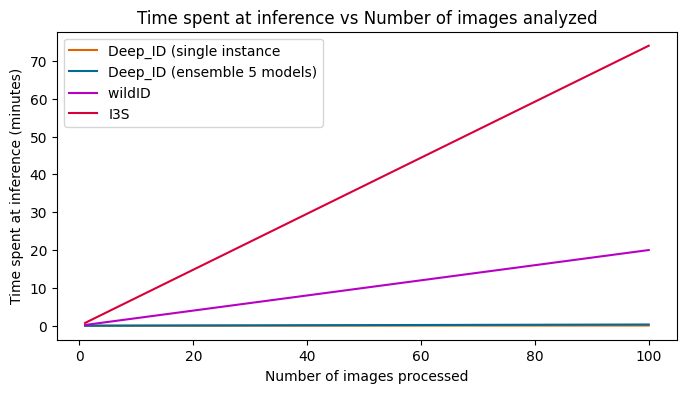

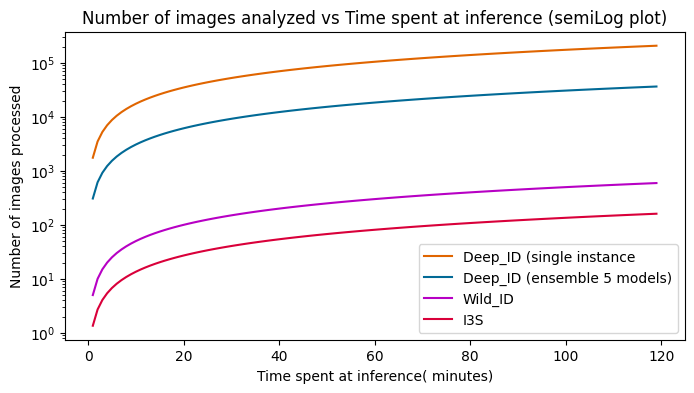

In [ ]:

# Original equations
n_ims = np.arange(1,101)

T_wildID = 0.2*n_ims
T_I3S =  0.74*n_ims
T_DeepID_ensemble= 0.00325*n_ims
T_DeepID_single= 0.00057*n_ims


# Reversed equations
T = np.arange(1, 2*60)

n_ims_wildID = (T) / 0.2
n_ims_I3S = (T ) / 0.74
n_ims_DeepID_ensemble = (T ) / 0.00325
n_ims_DeepID_single = (T ) / 0.00057



# Create two plots, one per view

# Images vs Time
plt.figure(figsize=(8, 4))


plt.plot(n_ims , T_DeepID_single, '-', color = c_deepId_single, label = 'Deep_ID (single instance')
plt.plot(n_ims , T_DeepID_ensemble, '-', color = c_deepId_ens_NoAug,  label = 'Deep_ID (ensemble 5 models)')
plt.plot(n_ims,  T_wildID , '-', color = c_wild_id, label = 'wildID ')
plt.plot(n_ims , T_I3S, '-', color = c_i3S, label = 'I3S')
plt.xlabel('Number of images processed')
plt.ylabel('Time spent at inference (minutes)')
plt.title('Time spent at inference vs Number of images analyzed')
plt.legend()
plt.show()

print('\n'*5)

plt.figure(figsize=(8, 4))
plt.semilogy(T,  n_ims_DeepID_single, '-', color = c_deepId_single, label='Deep_ID (single instance')
plt.semilogy(T,  n_ims_DeepID_ensemble, '-', color = c_deepId_ens_NoAug, label='Deep_ID (ensemble 5 models)')
plt.semilogy(T,  n_ims_wildID, '-', color = c_wild_id, label='Wild_ID')
plt.semilogy(T,  n_ims_I3S, '-',  color = c_i3S, label='I3S')
plt.xlabel('Time spent at inference( minutes)')
plt.ylabel('Number of images processed')
plt.title('Number of images analyzed vs Time spent at inference (semiLog plot)')
plt.legend()
plt.show()




# Confidence Index analysis to identify Unknown individuals

We ar going to do the analysis first in the full model **H_A09** and
- compare distribution score with previous methods (and with non ensemble methods)
- compute ROC and AUC for diferent values of P

- compare ROC AUC for different methods


First, we will predict all the data (using the original matrix and store the results in a dataframe with full name; prediction fo ensemble, and CI score.

The info is stored in dataframle **df_info** an the images are stores in array **images**

In [ ]:
data=np.load(npy_file, allow_pickle=True)
images=data['np_images']
if np.max(images) > 1: images = images/255.0

df_info = data['info_images']


We build all Deep_ID models and save each of them to disk as dictionnary.


In [ ]:
os.listdir(path+'/DATA_ANALYSIS_FINALS/DeepID_Models/')

['Deep_ID_Model.pickle',
 'H_B02_aug.pickle',
 'H_B05_aug.pickle',
 'H_B10_aug.pickle',
 'H_B20_aug.pickle']

In [ ]:
import pickle

recalculate = False
if recalculate:

  ## FULL MODEL (Deep_ID)
  models_A = ['H_A_09']
  all_models_A = [final_pass_dir+'/'+m for m in os.listdir(final_pass_dir) if m[0:3]=='H_A']
  this_model ='H_A_09'
  p=60
  models_to_aggregate = [m for m in all_models_A if this_model in m][0:5]
  print(models_to_aggregate)
  Deep_ID = create_ensemble_from_list(model_paths = models_to_aggregate, verbatim = True, fullpath=True)
  Deep_ID_wrap = {'Model':Deep_ID, 'metadata':this_model}

  #save model
  with open( path+'/DATA_ANALYSIS_FINALS/DeepID_Models/Deep_ID_Model.pickle', "wb") as f:
      pickle.dump(Deep_ID_wrap, f)

recalculate = False
if recalculate:
  ## AUGmENTED MODELS (P experiments)
  models_B_aug = ['H_B02_aug', 'H_B05_aug', 'H_B10_aug', 'H_B20_aug']
  all_models_B_aug = [augmented_dir+'/'+m for m in os.listdir(augmented_dir) if m[0:3]=='H_B']
  name_out_aug = 'ensemble_B_Aug'
  metrics_B_Aug = []

  for this_model in models_B_aug:
    p = int(this_model.split('_')[-2][1:])
    models_to_aggregate = [m for m in all_models_B_aug if this_model in m][0:5]
    print('creating model', this_model)
    ensemble = create_ensemble_from_list(model_paths = models_to_aggregate, verbatim = True, fullpath=True)
    #save model
    Deep_ID_wrap = {'Model':ensemble, 'metadata':this_model}
    print('saving model:', this_model)
    with open( path+'/DATA_ANALYSIS_FINALS/DeepID_Models/'+this_model+'.pickle', "wb") as f:
        pickle.dump(Deep_ID_wrap, f)
    print('saved.')

Now, we load the model and apply to a all the set (it takes about 120 secs to load model)

Models available

['Deep_ID_Model', 'H_B02_aug', 'H_B05_aug', 'H_B10_aug', 'H_B20_aug']

Deep_ID model is the single instance P60+final pass model


In [ ]:

data=np.load(npy_file, allow_pickle=True)
images=data['np_images']
if np.max(images) > 1: images = images/255.0

df_info = data['info_images']


path_models = path+'/DATA_ANALYSIS_FINALS/DeepID_Models/'
Model_Wrap  = 'Deep_ID_Model'

def load_deepModel(Model_wrap, path_models = path_models):
    with open(path_models + Model_Wrap+'.pickle', "rb") as f:
      Model_dict = pickle.load(f)
    model = Model_dict['Model']
    return model

In [ ]:
recalculate = False
if recalculate:

  Model_Wrap  = 'Deep_ID_Model'

  model = load_deepModel(Model_wrap='Deep_ID_Model', path_models = path_models)
  ## Predict and compute entropy for all dataset
  y_pred_all = predict_ensemble(X_data= images, ensemble= model, detail_prediction = False)
  y_pred_proba_all = predict_proba_ensemble(X_data = images,ensemble = model, detail_prediction = False)
  entropy_Deep_ID_all = proba2Entropy(y_pred_proba_all)
  CI_Deep_ID_all = 1-entropy_Deep_ID_all


  # extent df_info with preditions by Deep_ID
  df_info['DeepID_pred']=y_pred_all
  df_info['Deep_ID_Entropy']=entropy_Deep_ID_all
  df_info['Deep_ID_CI']=CI_Deep_ID_all







we do now a small P


In [ ]:
recalculate = False
if recalculate:
  # ============= B02===============
  Model_Wrap  = 'H_B02_aug'

  model = load_deepModel(Model_wrap=Model_Wrap, path_models = path_models)
  ## Predict and compute entropy for all dataset
  y_pred_all = predict_ensemble(X_data= images, ensemble= model, detail_prediction = False)
  y_pred_proba_all = predict_proba_ensemble(X_data = images,ensemble = model, detail_prediction = False)
  entropy_Deep_ID_all = proba2Entropy(y_pred_proba_all)
  CI_Deep_ID_all = 1-entropy_Deep_ID_all


  # extent df_info with preditions by Deep_ID
  df_info['H_B02_aug_pred']=y_pred_all
  df_info['H_B02_aug_Entropy']=entropy_Deep_ID_all
  df_info['H_B02_aug_CI']=CI_Deep_ID_all

  #============= B05 =================
  Model_Wrap  = 'H_B05_aug'

  model = load_deepModel(Model_wrap=Model_Wrap, path_models = path_models)
  ## Predict and compute entropy for all dataset
  y_pred_all = predict_ensemble(X_data= images, ensemble= model, detail_prediction = False)
  y_pred_proba_all = predict_proba_ensemble(X_data = images,ensemble = model, detail_prediction = False)
  entropy_Deep_ID_all = proba2Entropy(y_pred_proba_all)
  CI_Deep_ID_all = 1-entropy_Deep_ID_all


  # extent df_info with preditions by Deep_ID
  df_info['H_B05_aug_pred']=y_pred_all
  df_info['H_B05_aug_Entropy']=entropy_Deep_ID_all
  df_info['H_B05_aug_CI']=CI_Deep_ID_all

  # =============== B10 ==========================

  Model_Wrap  = 'H_B10_aug'

  model = load_deepModel(Model_wrap=Model_Wrap, path_models = path_models)
  ## Predict and compute entropy for all dataset
  y_pred_all = predict_ensemble(X_data= images, ensemble= model, detail_prediction = False)
  y_pred_proba_all = predict_proba_ensemble(X_data = images,ensemble = model, detail_prediction = False)
  entropy_Deep_ID_all = proba2Entropy(y_pred_proba_all)
  CI_Deep_ID_all = 1-entropy_Deep_ID_all


  # extent df_info with preditions by Deep_ID
  df_info['H_B10_aug_pred']=y_pred_all
  df_info['H_B10_aug_Entropy']=entropy_Deep_ID_all
  df_info['H_B10_aug_CI']=CI_Deep_ID_all


  # ====== ===B20 ===================

  Model_Wrap  = 'H_B20_aug'

  model = load_deepModel(Model_wrap=Model_Wrap, path_models = path_models)
  ## Predict and compute entropy for all dataset
  y_pred_all = predict_ensemble(X_data= images, ensemble= model, detail_prediction = False)
  y_pred_proba_all = predict_proba_ensemble(X_data = images,ensemble = model, detail_prediction = False)
  entropy_Deep_ID_all = proba2Entropy(y_pred_proba_all)
  CI_Deep_ID_all = 1-entropy_Deep_ID_all


  # extent df_info with preditions by Deep_ID
  df_info['H_B20_aug_pred']=y_pred_all
  df_info['H_B20_aug_Entropy']=entropy_Deep_ID_all
  df_info['H_B20_aug_CI']=CI_Deep_ID_all


  df_info.to_csv(results_dir +'/df_info_predictions_full.csv', index=False)

In [ ]:
df_info = pd.read_csv(results_dir +'/df_info_predictions_full.csv')
df_info

pic                         path   ind_name group    P  \
0          Adam_000.jpg            Adam\Adam_000.jpg       Adam     A   40   
1          Adam_001.jpg            Adam\Adam_001.jpg       Adam     A    5   
2          Adam_002.jpg            Adam\Adam_002.jpg       Adam     A    2   
3          Adam_003.jpg            Adam\Adam_003.jpg       Adam     A   60   
4          Adam_004.jpg            Adam\Adam_004.jpg       Adam     A   20   
...                 ...                          ...        ...   ...  ...   
1625  Ravel_juv_045.jpg  Ravel_juv/Ravel_juv_045.jpg  Ravel_juv     Y  999   
1626  Ravel_juv_046.jpg  Ravel_juv/Ravel_juv_046.jpg  Ravel_juv     Y  999   
1627  Ravel_juv_047.jpg  Ravel_juv/Ravel_juv_047.jpg  Ravel_juv     Y  999   
1628  Ravel_juv_048.jpg  Ravel_juv/Ravel_juv_048.jpg  Ravel_juv     Y  999   
1629  Ravel_juv_049.jpg  Ravel_juv/Ravel_juv_049.jpg  Ravel_juv     Y  999   

      B_adult_test_val  id  DeepID_pred  Deep_ID_Entropy  Deep_ID_CI  ...  \
0                  999   0            0         0.000193    0.999807  ...   
1                  999   0            0         0.000347    0.999653  ...   
2                  999   0            0         0.000019    0.999981  ...   
3                  999   0            0         0.000002    0.999998  ...   
4                  999   0            0         0.000014    0.999986  ...   
...                ...  ..          ...              ...         ...  ...   
1625               999  29            8         0.649272    0.350728  ...   
1626               999  29           12         0.645544    0.354456  ...   
1627               999  29            7         0.713763    0.286237  ...   
1628               999  29            6         0.502579    0.497421  ...   
1629               999  29           10         0.665490    0.334510  ...   

      H_B02_aug_CI  H_B05_aug_pred  H_B05_aug_Entropy  H_B05_aug_CI  \
0         0.432042               0           0.102191      0.897809   
1         0.571084               0           0.000003      0.999997   
2         0.999853               0           0.000021      0.999979   
3         0.989450               0           0.000002      0.999998   
4         0.723896               0           0.000935      0.999065   
...            ...             ...                ...           ...   
1625      0.487417               6           0.526055      0.473945   
1626      0.566859               8           0.423582      0.576418   
1627      0.627344              18           0.485219      0.514781   
1628      0.495414               6           0.283124      0.716876   
1629      0.487078              11           0.689374      0.310626   

      H_B10_aug_pred  H_B10_aug_Entropy  H_B10_aug_CI  H_B20_aug_pred  \
0                  0           0.176987      0.823013               0   
1                  0           0.000022      0.999978               0   
2                  0           0.000027      0.999973               0   
3                  0           0.000002      0.999998               0   
4                  0           0.000729      0.999271               0   
...              ...                ...           ...             ...   
1625               6           0.423764      0.576236              12   
1626              10           0.566602      0.433398               1   
1627              18           0.515099      0.484901              12   
1628               6           0.089041      0.910959               6   
1629               9           0.606954      0.393046               9   

      H_B20_aug_Entropy  H_B20_aug_CI  
0              0.212344      0.787656  
1              0.000182      0.999818  
2              0.000573      0.999427  
3              0.000107      0.999893  
4              0.001207      0.998793  
...                 ...           ...  
1625           0.438667      0.561333  
1626           0.499980      0.500020  
1627           0.573053      0.426947  
1628           0.057514     

We restrict to test set, both for known and for unknowns
- df_info['P'] = 100
- df_info['B_adult_test_val'] == 1
and add an unknown column (unknwon =1, known = 0)

In [ ]:
df_full_test = df_info[(df_info['P'] == 100) |  (df_info['B_adult_test_val'] == 1)]

df_full_test.info()
df_full_test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 5 to 1283
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pic                350 non-null    object 
 1   path               350 non-null    object 
 2   ind_name           350 non-null    object 
 3   group              350 non-null    object 
 4   P                  350 non-null    int64  
 5   B_adult_test_val   350 non-null    int64  
 6   id                 350 non-null    int64  
 7   DeepID_pred        350 non-null    int64  
 8   Deep_ID_Entropy    350 non-null    float64
 9   Deep_ID_CI         350 non-null    float64
 10  H_B02_aug_pred     350 non-null    int64  
 11  H_B02_aug_Entropy  350 non-null    float64
 12  H_B02_aug_CI       350 non-null    float64
 13  H_B05_aug_pred     350 non-null    int64  
 14  H_B05_aug_Entropy  350 non-null    float64
 15  H_B05_aug_CI       350 non-null    float64
 16  H_B10_aug_pred     350 non-nul

pic               path ind_name group    P  B_adult_test_val  id  \
5   Adam_005.jpg  Adam\Adam_005.jpg     Adam     A  100               999   0   
9   Adam_009.jpg  Adam\Adam_009.jpg     Adam     A  100               999   0   
12  Adam_012.jpg  Adam\Adam_012.jpg     Adam     A  100               999   0   
18  Adam_018.jpg  Adam\Adam_018.jpg     Adam     A  100               999   0   
22  Adam_022.jpg  Adam\Adam_022.jpg     Adam     A  100               999   0   

    DeepID_pred  Deep_ID_Entropy  Deep_ID_CI  ...  H_B02_aug_CI  \
5             0     1.608722e-03    0.998391  ...      0.555841   
9             0     9.953498e-07    0.999999  ...      0.677532   
12            0     1.196740e-03    0.998803  ...      0.593703   
18            0     9.601118e-02    0.903989  ...      0.645215   
22            0     1.064054e-04    0.999894  ...      0.641965   

    H_B05_aug_pred  H_B05_aug_Entropy  H_B05_aug_CI  H_B10_aug_pred  \
5                0           0.242342      0.757658               0   
9                0           0.004776      0.995224               0   
12               0           0.093624      0.906376               0   
18               0           0.347421      0.652579               0   
22               0           0.293442      0.706558               0   

    H_B10_aug_Entropy  H_B10_aug_CI  H_B20_aug_pred  H_B20_aug_Entropy  \
5            0.169806      0.830194               0           0.027213   
9            0.000009      0.999991               0           0.000139   
12           0.162653      0.837347               0           0.149924   
18           0.189280      0.810720               0           0.133756   
22           0.170759      0.829241               0           0.170020   

    H_B20_aug_CI  
5       0.972787  
9       0.999861  
12      0.850076  
18      0.866244  
22      0.829980  

[5 rows x 22 columns]

We also combine the data from the previous methods in the same dataframe to have all at one place

In [ ]:
df_previous = pd.read_csv(results_dir +'/results_predictions_previous_with_path.csv')
def convert_path(path):
  a1 = path.split('\\')[13:]
  ind_name = a1[0]
  pic = a1[1][:-3]+'jpg'
  return pic

df_previous['pic'] = df_previous['Path_compared'].apply(convert_path)
df_full_test['unknown'] = (df_full_test['B_adult_test_val']==1)



<ipython-input-40-27609526b103>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full_test['unknown'] = (df_full_test['B_adult_test_val']==1)


In [ ]:
df_previous_test = df_previous[ ['ix', 'pic', 'Pic_compared',  'I3S_optimal_match', 'I3S_optimal_score', 'Wild-ID_match', 'Wild-ID_score' ]]
df_previous_test.head()

ix           pic Pic_compared I3S_optimal_match  I3S_optimal_score  \
0   0  Adam_005.jpg         Adam              Adam               1511   
1   1  Adam_009.jpg         Adam              Adam                879   
2   2  Adam_012.jpg         Adam              Adam               1012   
3   3  Adam_018.jpg         Adam              Adam               2296   
4   4  Adam_022.jpg         Adam              Adam               1150   

  Wild-ID_match  Wild-ID_score  
0          Adam       0.137502  
1          Adam       0.079126  
2          Adam       0.100002  
3          Inox       0.100003  
4          Adam       0.285715

In [ ]:
merged_df = pd.merge(df_full_test , df_previous_test, on='pic', how='outer')
merged_df.head()



pic               path ind_name group    P  B_adult_test_val  id  \
0  Adam_005.jpg  Adam\Adam_005.jpg     Adam     A  100               999   0   
1  Adam_009.jpg  Adam\Adam_009.jpg     Adam     A  100               999   0   
2  Adam_012.jpg  Adam\Adam_012.jpg     Adam     A  100               999   0   
3  Adam_018.jpg  Adam\Adam_018.jpg     Adam     A  100               999   0   
4  Adam_022.jpg  Adam\Adam_022.jpg     Adam     A  100               999   0   

   DeepID_pred  Deep_ID_Entropy  Deep_ID_CI  ...  H_B20_aug_pred  \
0            0     1.608722e-03    0.998391  ...               0   
1            0     9.953498e-07    0.999999  ...               0   
2            0     1.196740e-03    0.998803  ...               0   
3            0     9.601118e-02    0.903989  ...               0   
4            0     1.064054e-04    0.999894  ...               0   

   H_B20_aug_Entropy  H_B20_aug_CI  unknown  ix  Pic_compared  \
0           0.027213      0.972787    False   0          Adam   
1           0.000139      0.999861    False   1          Adam   
2           0.149924      0.850076    False   2          Adam   
3           0.133756      0.866244    False   3          Adam   
4           0.170020      0.829980    False   4          Adam   

   I3S_optimal_match  I3S_optimal_score  Wild-ID_match  Wild-ID_score  
0               Adam               1511           Adam       0.137502  
1               Adam                879           Adam       0.079126  
2               Adam               1012           Adam       0.100002  
3               Adam               2296           Inox       0.100003  
4               Adam               1150           Adam       0.285715  

[5 rows x 29 columns]

Just  to test Nicolas data and mine

In [ ]:
flag_equal = (merged_df['ind_name'] == merged_df['Pic_compared'])
flag_equal.describe()

count      350
unique       1
top       True
freq       350
dtype: object

## ROC



In [ ]:
merged_df

pic                 path ind_name    group    P  \
0     Adam_005.jpg    Adam\Adam_005.jpg     Adam        A  100   
1     Adam_009.jpg    Adam\Adam_009.jpg     Adam        A  100   
2     Adam_012.jpg    Adam\Adam_012.jpg     Adam        A  100   
3     Adam_018.jpg    Adam\Adam_018.jpg     Adam        A  100   
4     Adam_022.jpg    Adam\Adam_022.jpg     Adam        A  100   
..             ...                  ...      ...      ...  ...   
345  Nayla_051.jpg  Nayla\Nayla_051.jpg    Nayla  B_adult  999   
346  Nayla_053.jpg  Nayla\Nayla_053.jpg    Nayla  B_adult  999   
347  Nayla_055.jpg  Nayla\Nayla_055.jpg    Nayla  B_adult  999   
348  Nayla_057.jpg  Nayla\Nayla_057.jpg    Nayla  B_adult  999   
349  Nayla_059.jpg  Nayla\Nayla_059.jpg    Nayla  B_adult  999   

     B_adult_test_val  id  DeepID_pred  Deep_ID_Entropy  Deep_ID_CI  ...  \
0                 999   0            0     1.608722e-03    0.998391  ...   
1                 999   0            0     9.953498e-07    0.999999  ...   
2                 999   0            0     1.196740e-03    0.998803  ...   
3                 999   0            0     9.601118e-02    0.903989  ...   
4                 999   0            0     1.064054e-04    0.999894  ...   
..                ...  ..          ...              ...         ...  ...   
345                 1  24            2     6.840178e-01    0.315982  ...   
346                 1  24           16     5.830144e-01    0.416986  ...   
347                 1  24           12     6.415851e-01    0.358415  ...   
348                 1  24           16     5.356618e-01    0.464338  ...   
349                 1  24            2     6.933775e-01    0.306623  ...   

     H_B20_aug_pred  H_B20_aug_Entropy  H_B20_aug_CI  unknown   ix  \
0                 0           0.027213      0.972787    False    0   
1                 0           0.000139      0.999861    False    1   
2                 0           0.149924      0.850076    False    2   
3                 0           0.133756      0.866244    False    3   
4                 0           0.170020      0.829980    False    4   
..              ...                ...           ...      ...  ...   
345              12           0.266365      0.733635     True  248   
346              12           0.617300      0.382700     True  249   
347              12           0.218385      0.781615     True  250   
348               6           0.648532      0.351468     True  251   
349               6           0.406848      0.593152     True  252   

     Pic_compared  I3S_optimal_match  I3S_optimal_score  Wild-ID_match  \
0            Adam               Adam               1511           Adam   
1            Adam               Adam                879           Adam   
2            Adam               Adam               1012           Adam   
3            Adam               Adam               2296           Inox   
4            Adam               Adam               1150           Adam   
..            ...                ...                ...            ...   
345         Nayla            Sarkozy               3851           Yobi   
346         Nayla               Inox               4589         Turtle   
347         Nayla               Wolf               4612        Herbert   
348         Nayla             Pansar               2912         Albert   
349         Nayla              Aponi               4317          Karin   

     Wild-ID_score  
0         0.137502  
1         0.079126  
2         0.100002  
3         0.100003  
4         0.285715  
..             ...  
345       0.100004  
346       0.024246  
347       0.006061  
348       0.028575  
349       0.100001  

[350 rows x 29 columns]

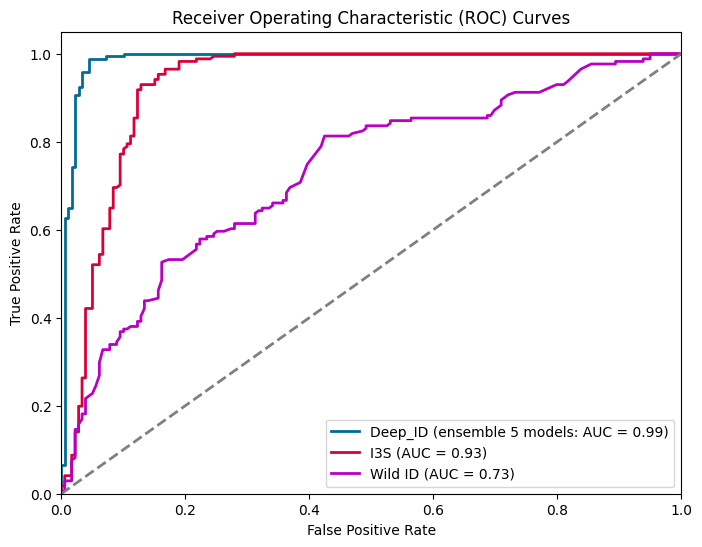

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc


true_labels = merged_df['unknown']
score_DeepID = 1-merged_df['Deep_ID_CI']
score_I3S = merged_df['I3S_optimal_score']
score_wildID = 1-merged_df['Wild-ID_score']


fpr1, tpr1, _ = roc_curve(true_labels, score_DeepID )
fpr2, tpr2, _ = roc_curve(true_labels, score_I3S)
fpr3, tpr3, _ = roc_curve(true_labels, score_wildID)


roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

# Plot the ROC curves with labels
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color = c_deepId_ens_NoAug, lw=2, label=f'Deep_ID (ensemble 5 models: AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2,  color =c_i3S, lw=2, label=f'I3S (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color = c_wild_id, lw=2, label=f'Wild ID (AUC = {roc_auc3:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


## AUC for different P

In [ ]:
merged_df['score_DeepID']  = 1-merged_df['Deep_ID_CI']
merged_df.columns

Index(['pic', 'path', 'ind_name', 'group', 'P', 'B_adult_test_val', 'id',
       'DeepID_pred', 'Deep_ID_Entropy', 'Deep_ID_CI', 'H_B02_aug_pred',
       'H_B02_aug_Entropy', 'H_B02_aug_CI', 'H_B05_aug_pred',
       'H_B05_aug_Entropy', 'H_B05_aug_CI', 'H_B10_aug_pred',
       'H_B10_aug_Entropy', 'H_B10_aug_CI', 'H_B20_aug_pred',
       'H_B20_aug_Entropy', 'H_B20_aug_CI', 'unknown', 'ix', 'Pic_compared',
       'I3S_optimal_match', 'I3S_optimal_score', 'Wild-ID_match',
       'Wild-ID_score', 'score_DeepID'],
      dtype='object')

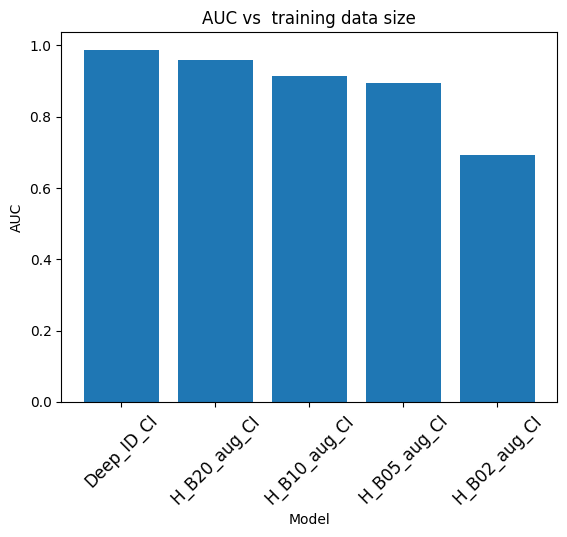

In [ ]:
deepID_df = merged_df[['Deep_ID_CI', 'H_B02_aug_CI', 'H_B05_aug_CI', 'H_B10_aug_CI', 'H_B20_aug_CI', 'unknown']]

score_DeepID = 1-merged_df['Deep_ID_CI']
score_20 = 1-merged_df['H_B20_aug_CI']
score_10 = 1-merged_df[ 'H_B10_aug_CI']
score_05 = 1-merged_df['H_B05_aug_CI']
score_02 = 1-merged_df['H_B02_aug_CI']

true_labels = deepID_df ['unknown']
fpr1, tpr1, _ = roc_curve(true_labels, score_DeepID )
fpr2, tpr2, _ = roc_curve(true_labels, score_20 )
fpr3, tpr3, _ = roc_curve(true_labels, score_10 )
fpr4, tpr4, _ = roc_curve(true_labels, score_05)
fpr5, tpr5, _ = roc_curve(true_labels, score_02 )

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)


names = ['Deep_ID_CI', 'H_B20_aug_CI', 'H_B10_aug_CI','H_B05_aug_CI', 'H_B02_aug_CI']
values = [roc_auc1 , roc_auc2 , roc_auc3 , roc_auc4 , roc_auc5 ]

# Creating the bar plot
plt.bar(names, values)

# Adding labels and title
plt.xlabel('Model')
plt.xticks(names, rotation=45, fontsize=12)
plt.ylabel('AUC')
plt.title('AUC vs  training data size')

# Display the plot
plt.show()


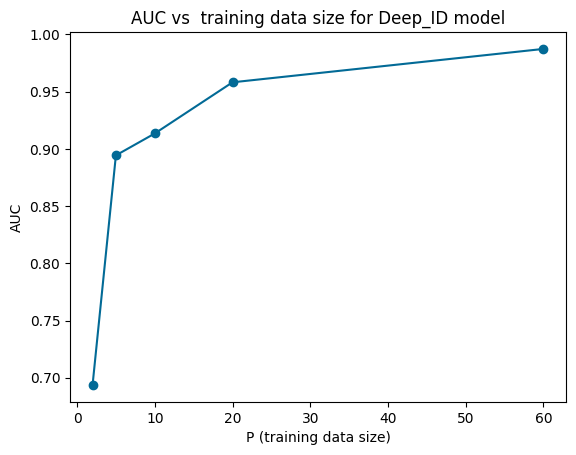

In [ ]:
P = [60,20,10,5,2]
values = [roc_auc1 , roc_auc2 , roc_auc3 , roc_auc4 , roc_auc5 ]

# Creating the bar plot
plt.plot(P, values, marker ='o', color = c_deepId_ens_NoAug)

# Adding labels and title
plt.xlabel('P (training data size)')
plt.ylabel('AUC')
plt.title('AUC vs  training data size for Deep_ID model')

# Display the plot
plt.show()


Now we can do some statistic

179 knowns and 171 unknowns


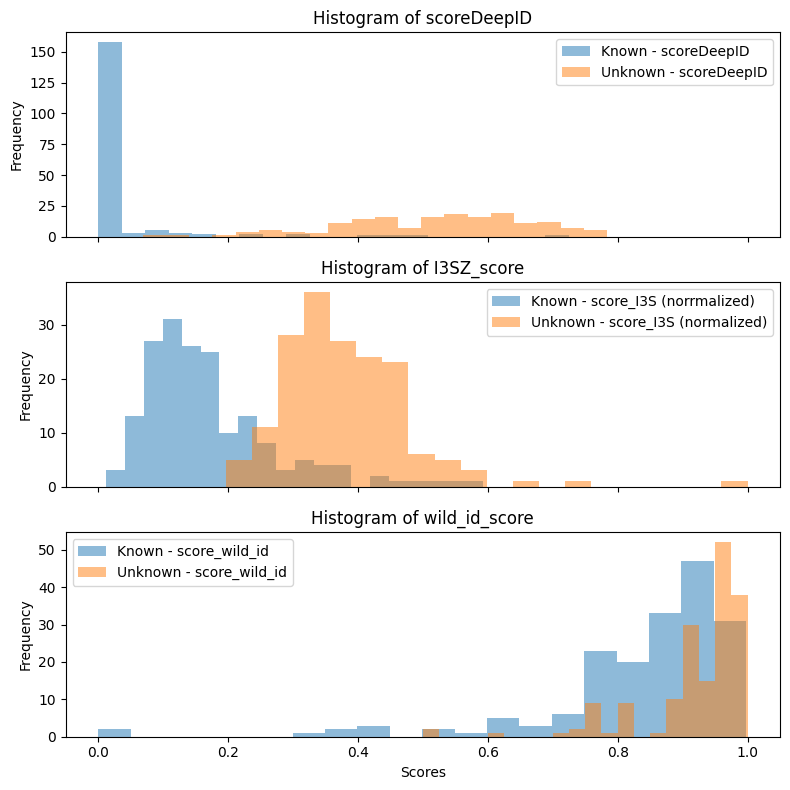

In [ ]:
is_known  = (merged_df.unknown ==0)
is_unknown  = (merged_df.unknown ==1)

print(f'{sum(is_known)} knowns and {sum(is_unknown)} unknowns'  )

# Creating a figure with three subplots, sharing the x-axis
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

# Histogram for 'scoreDeepID'
axs[0].hist(merged_df.loc[is_known, 'score_DeepID'], bins=20, alpha=0.5, label='Known - scoreDeepID')
axs[0].hist(merged_df.loc[is_unknown, 'score_DeepID'], bins=20, alpha=0.5, label='Unknown - scoreDeepID')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].set_title('Histogram of scoreDeepID')

merged_df['normalized_score_I3S']= merged_df['I3S_optimal_score']/merged_df['I3S_optimal_score'].max()
# Histogram for 'I3SZ_score'
axs[1].hist(merged_df.loc[is_known, 'normalized_score_I3S'], bins=20, alpha=0.5, label='Known - score_I3S (norrmalized)')
axs[1].hist(merged_df.loc[is_unknown, 'normalized_score_I3S'], bins=20, alpha=0.5, label='Unknown - score_I3S (normalized)')
axs[1].set_ylabel('Frequency')
axs[1].legend()
axs[1].set_title('Histogram of I3SZ_score')

# Histogram for 'wild_id_score'
axs[2].hist(1-merged_df.loc[is_known, 'Wild-ID_score'], bins=20, alpha=0.5, label='Known - score_wild_id')
axs[2].hist(1-merged_df.loc[is_unknown, 'Wild-ID_score'], bins=20, alpha=0.5, label='Unknown - score_wild_id')
axs[2].set_ylabel('Frequency')
axs[2].legend()
axs[2].set_title('Histogram of wild_id_score')



# Set the x-label for the bottom subplot
axs[2].set_xlabel('Scores')

# Show the plot
plt.tight_layout()
plt.show()

## **Mixed ensemble model with Known and Unknowns**

Text(0.5, 1.0, 'wild_id score')

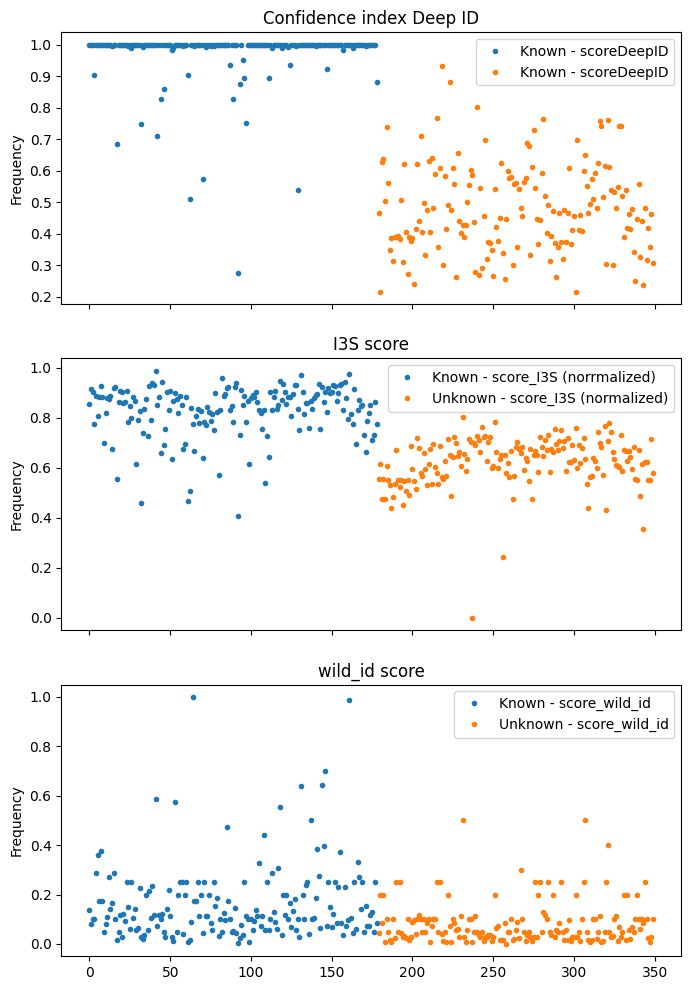

In [ ]:
ix = np.arange(len(merged_df))
is_known  = (merged_df.unknown ==0)
is_unknown  = (merged_df.unknown ==1)

# Creating a figure with three subplots, sharing the x-axis
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 12))

# Histogram for 'scoreDeepID'
axs[0].plot(ix[is_known], 1-merged_df.loc[is_known, 'score_DeepID'], '.', label='Known - scoreDeepID')
axs[0].plot(ix[is_unknown], 1-merged_df.loc[is_unknown, 'score_DeepID'], '.', label='Known - scoreDeepID')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].set_title('Confidence index Deep ID')

merged_df['normalized_score_I3S']= 1- merged_df['I3S_optimal_score']/merged_df['I3S_optimal_score'].max()
# Histogram for 'I3SZ_score'
axs[1].plot(ix[is_known], merged_df.loc[is_known, 'normalized_score_I3S'], '.', label='Known - score_I3S (norrmalized)')
axs[1].plot(ix[is_unknown], merged_df.loc[is_unknown, 'normalized_score_I3S'], '.', label='Unknown - score_I3S (normalized)')
axs[1].set_ylabel('Frequency')
axs[1].legend()
axs[1].set_title('I3S score')


# Histogram for 'wild_id_score'
axs[2].plot(ix[is_known], merged_df.loc[is_known, 'Wild-ID_score'], '.', label='Known - score_wild_id')
axs[2].plot(ix[is_unknown], merged_df.loc[is_unknown, 'Wild-ID_score'],'.', label='Unknown - score_wild_id')
axs[2].set_ylabel('Frequency')
axs[2].legend()
axs[2].set_title('wild_id score')


We stop runtime

In [ ]:
from google.colab import runtime
runtime.unassign()